# US COLLEGE DATASET 
## Predict the average annual total cost of attendance 

by *Ignacio Carracedo and Nan Wang*


## SUMMARY

This notebook builts a model that predicts the average annual total cost of attendance for institutions primarily following an academic year-based calendar system. The average annual cost of attendance includes tuition and fees, books and supplies, and living expenses for all full-time, first-time, degree-/certificate-seeking undergraduates who receive Title IV aid.

We would like to predict the cost. In addition, we will investigate what features have more influence in the attendance cost, e.g., the institution's location, degrees offered, size, and its students' demography. 


**1.LOAD DATA** 

    1.1. Download the data 
    1.2. Concatenate the data   
    1.3. Look at the data structure
    1.4. Select a dataset to analyze 
    
**2.EXPLORE DATA **

    2.1. Missing values    
    2.2. Feature exploration
    2.3. Separate a test dataset from the training dataset
    2.4. Discover and visualize data to gain insights
  
**3.MODEL**

    3.1. Custom transformers    
    3.2. Pipeline    
    3.3. Model selection    
    3.4. Model tune up    
    3.5. Final model 
    3.6. Additional comments

**Prelude**: Show the Py notebook running enviroment and versions of the libraries we are working with and import all libraries needed.

In [1]:
%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib,scikit-learn

2017-02-14 

CPython 3.5.1
IPython 4.2.0

numpy 1.12.0
pandas 0.18.1
matplotlib 2.0.0
scikit-learn 0.18.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [1]:
# Import packages and libraries used in this notebook
import os
from os import listdir
from os.path import isfile, join
import zipfile
from six.moves import urllib

import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

## 1. LOAD DATA

### 1.1. Download the data

The college data set can be downloaded from 'https://collegescorecard.ed.gov/data/'. Data is compressed in a zip file that has a *.csv* file per school year.

In [5]:
""" Define the location of the data in the web and the 
    downloading location in our local project folder """
DOWNLOAD_ROOT = "https://ed-public-download.apps.cloud.gov/downloads/"
COLLEGE_PATH = "datasets/collegescorecard"
COLLEGE_URL = DOWNLOAD_ROOT+ "/CollegeScorecard_Raw_Data.zip"

The following function will:

* Download dataset into datasets\collegescorecard\CollegeScorecard_Raw_Data folder.
* Extract zip file

In [4]:
def fetch_housing_data(college_url=COLLEGE_URL, college_path=COLLEGE_PATH):
    """ downloads data from college_url and unzip it into college_path"""
    
    os.makedirs(college_path, exist_ok=True)
    zip_path = os.path.join(college_path, "CollegeScorecard_Raw_Data.zip")
    urllib.request.urlretrieve(college_url, zip_path)
    college_zip = zipfile.ZipFile(zip_path, 'r')
    college_zip.extractall(path=college_path)
    college_zip.close()

In [ ]:
fetch_housing_data()

### 1.2. Concatenate the data 

There is one csv file for each school year, the following function reads the .csv files separately and concatenate them to one data frame. During this process a YEAR column is added to show the school year of each observation. The function also takes a string as an argument and will only concatenate files that have that string in their name. 

Because of memory issues, we pass the string *'201'* to the function to select a subset of the files, the ones for 2010 and after.

In [19]:
def load_college_data(college_path=COLLEGE_PATH+'/CollegeScorecard_Raw_Data', string_include = "" ):
    """ concatenates csv files into one data frame. Function accepts paramenter string to filter files"""
    college_list = []
    onlyfiles = [f for f in listdir(college_path) if (isfile(join(college_path, f)))
                 and (".csv" in f) and (string_include in f)]
    
    for f in onlyfiles:
        print("Reading %s ..." %f)
        csv_path = os.path.join(college_path, f)
        aux = pd.read_csv(csv_path,low_memory=False)
        aux['YEAR']=int(f.split('MERGED')[1].split('_')[0])
        college_list.append(aux)
        del aux 
    print("Concatenating files ...")
    return pd.concat(college_list)

In [ ]:
#get a list of files in directory that are .csv in and after 2010
college = load_college_data(string_include="201")

Reading MERGED2010_11_PP.csv ...
Reading MERGED2011_12_PP.csv ...
Reading MERGED2012_13_PP.csv ...
Reading MERGED2013_14_PP.csv ...
Reading MERGED2014_15_PP.csv ...


Now we have one data frame with all the data. We save the data frame so we don't have to repeat this process again. 

In [7]:
college.to_csv(COLLEGE_PATH+'/college.csv',index=False) #save

In [ ]:
# This will allow us to start this notebook from this cell if we uncomment the read_csv line below:
#college = pd.read_csv(COLLEGE_PATH+'/college.csv', encoding = "ISO-8859-1") 

### 1.3. Look at the data structure

We can now check the size of the data frame and explore the first 5 columns to get a general idea of what it looks like

In [6]:
print("Rows: %s, Columns: %s " %(college.shape[0],college.shape[1]))
college.head()

Rows: 38389, Columns: 1744 


,﻿UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM,YEAR
0,100654,00100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,0.000000,1198.0,NaN,NaN,1,0.4771,0.5229,NaN,1515.0,2010
1,100663,00105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,0.291016,1536.0,NaN,NaN,1,0.4170,0.5830,NaN,2842.0,2010
2,100690,02503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,0.000000,13.0,NaN,NaN,1,0.4649,0.5351,NaN,316.0,2010
3,100706,00105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,0.336907,653.0,NaN,NaN,1,0.5297,0.4703,NaN,1085.0,2010
4,100724,00100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,0.000000,1138.0,NaN,NaN,1,0.4097,0.5903,NaN,2054.0,2010


We can see that there are missing values in the data. Check the non-missing average annual cost (COSTT4_A) change over the 5 years using box plots and also check that the institutions that have non-missing COST4_A are the same for all the years.

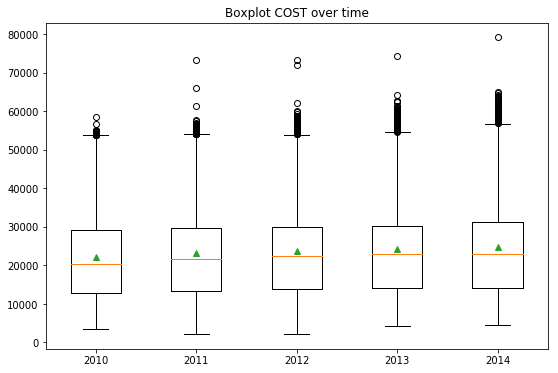

' ******** All years have the same institutions with the feature cost ******** '

In [7]:
def institutions_cost_years (df):
    """ This function inputs a dataframe and returns if the institutions with feature COSTT4_A
    are the same for each year or if at least one year is different. It returns a string with a message."""
    # create sorted list for institutions with non-missing attendance cost for all years
    total = [sorted(list(df[df.YEAR==2014].ix[:, 0].dropna(axis=0).unique())) for x in df.YEAR.unique()] 
    #return result
    if all(x == total[0] for x in total):
        return(" ******** All years have the same institutions with the feature cost ******** ")
    else:
        return("******** Not all years have the same institutions with the feature cost ******** ")
    
###### BOXPLOT of COSTT_A over time
year_cost_data = []

for y in college.YEAR.unique():
    year_cost_data.append(college[college['YEAR']==y]["COSTT4_A"].dropna(axis=0))
    
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
ax.boxplot(year_cost_data, showmeans=True)
plt.title("Boxplot of Average Annual Attendance COST over time")
plt.xticks(range(1,6),list(college.YEAR.unique()))
plt.show()

# check for same institutions
institutions_cost_years(college)

The mean and percentiles (0, 25, 50, 75, 100) of the annual average cost all increased in the 2014-2015 school year compared to 2010-2011 school year. Therefore, we are going to use the data from 2014-2015 school year since it is the most up to date and do not consider prior year's information. Also, each year has the same institutions (checked with *institutions_cost_years* function)

### 1.4. Select a data set to analyze

A data frame containing 2014-2015 school year information is created below.

In [8]:
college2014 = college[college['YEAR']==2014] #filer
college2014.to_csv(COLLEGE_PATH+'/college2014.csv',index=False) # save
del college # delete to save memory

Next time we run the notebook we could start using the following cell that loads the data of 2014 back in. It will be faster.

In [4]:
college2014 = pd.read_csv(COLLEGE_PATH+'/college2014.csv', encoding = "ISO-8859-1", low_memory=False)

## 2.DATA EXPLORATION

### 2.1. Missing values 

Investigate missing values. Next cell defines a function to return the data frame with all the columns that have a percentage of missing values below a threshold. We will use this function to select features to feed into our machine learning algorithm because the features with fewer missing values are likely more useful/important.

Since the annual average cost COSTT4_A is the target variable  we decided to select the subset where COSTT4_A is not missing.

In [5]:
college2014 = college2014.dropna(axis=0, subset=["COSTT4_A"])
print("Rows: %s, Columns: %s " %(college2014.shape[0],college2014.shape[1]))

Rows: 4030, Columns: 1744 


We end up with 4030 observations after dropping any missing values for the annual average cost.
Using the missing value function defined below, we can reduce features further by selecting columns with a missing value threshold.

In [6]:
def cols_few_missing_values(df, threshold=0):
    
    '''this function takes a DataFrame and a threshold as parameters and 
       returns the DataFrame with the columns that have a percentage of
       missing values equal or less than the threshold'''

    columns = []
    total_rows = college2014.shape[0]
    missing_values = dict(college2014.isnull().sum())
    
    for key, value in missing_values.items():
        if (value/total_rows) <= threshold:
            columns.append(key)    
            
    df = df[columns]
    print("*** Keeping %s out of %s columns with missing values threashold of %s ***\n"
          %(len(columns), total_rows, threshold))
    return (df)

In [7]:
for i in (np.sort(cols_few_missing_values(college2014,0.1).columns))[:50]:
    print(i)
print("\n----- output trimmed -----")

*** Keeping 468 out of 4030 columns with missing values threashold of 0.1 ***

?UNITID
AANAPII
ACCREDAGENCY
AGE_ENTRY
ANNHI
APPL_SCH_N
APPL_SCH_PCT_GE2
APPL_SCH_PCT_GE3
APPL_SCH_PCT_GE4
APPL_SCH_PCT_GE5
AVGFACSAL
CCBASIC
CCSIZSET
CCUGPROF
CDR3
CDR3_DENOM
CIP01ASSOC
CIP01BACHL
CIP01CERT1
CIP01CERT2
CIP01CERT4
CIP03ASSOC
CIP03BACHL
CIP03CERT1
CIP03CERT2
CIP03CERT4
CIP04ASSOC
CIP04BACHL
CIP04CERT1
CIP04CERT2
CIP04CERT4
CIP05ASSOC
CIP05BACHL
CIP05CERT1
CIP05CERT2
CIP05CERT4
CIP09ASSOC
CIP09BACHL
CIP09CERT1
CIP09CERT2
CIP09CERT4
CIP10ASSOC
CIP10BACHL
CIP10CERT1
CIP10CERT2
CIP10CERT4
CIP11ASSOC
CIP11BACHL
CIP11CERT1
CIP11CERT2

----- output trimmed -----


We set the threshold of missing values to 10% and reduced the features to 468. 

*NOTE*: Output is trimmed to show only 50 columns.

Then we went through the features, further reducing them using the common knowledge regarding which factors might affect college attendance cost, mostly are school and student characteristics.

Here are the 77 features we selected to model. 

* CONTROL: Public, Private nonprofit, Private for-profit
* MAIN: Flag for main campus
* REGION: Region where school is located
* ICLEVEL: institutional_characteristics.level 4-year,2-year,Less-than-2-year
* NUMBRANCH: Number of branch campuses
* PREDDEG: "Predominant undergraduate degree awarded 0 Not classified 1 Predominantly certificate-degree granting 2 Predominantlyassociate's-degree granting 3 Predominantly bachelor's-degree granting 4 Entirely graduate-degree granting"
* HIGHDEG: "Highest degree awarded 0 Non-degree-granting 1 Certificate degree 2 Associate degree 3 Bachelor's degree 4 Graduate degree"
* PBI: Flag for predominantly black institution
* MENONLY: Flag for men-only college
* WOMENONLY: Flag for women-only college
* PCIP01", "PCIP03","PCIP04", "PCIP05", "PCIP09", "PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15", "PCIP16", "PCIP19", "PCIP22", "PCIP23", "PCIP24", "PCIP25", "PCIP26", "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38", "PCIP39", "PCIP40", "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47", "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54" : types of degrees offered.
* UGDS_2MOR: Total share of enrollment of undergraduate degree-seeking students who are two or more races
* UGDS_AIAN: Total share of enrollment of undergraduate degree-seeking students who are American Indian/Alaska Native
* UGDS_ASIAN: Total share of enrollment of undergraduate degree-seeking students who are Asian
* UGDS_BLACK: Total share of enrollment of undergraduate degree-seeking students who are black
* UGDS_HISP: Total share of enrollment of undergraduate degree-seeking students who are Hispanic
* UGDS_WHITE: Total share of enrollment of undergraduate degree-seeking students who are white
* UGDS_NHPI:Total share of enrollment of undergraduate degree-seeking students who are Native Hawaiian/Pacific Islander
* UGDS_NRA: Total share of enrollment of undergraduate degree-seeking students who are non-resident aliens
* UGDS_UNKN: Total share of enrollment of undergraduate degree-seeking students whose race is unknown
* UGDS_MEN: 
* UGDS_WOMEN
* UG: Enrollment of all undergraduate students
* UGDS: Enrollment of undergraduate certificate/degree-seeking students
* CCSIZSET: Carnegie Classification -- size and setting
* VETERAN: Share of veteran students
* DISTANCEONLY: Flag for distance-education-only education
* AGE_ENTRY: Average age of entry, via SSA data

In [13]:
# feature selection
columns = ['COSTT4_A','CONTROL', 'MAIN', 'REGION', 'ICLEVEL', 'NUMBRANCH','PREDDEG',
           'HIGHDEG','MENONLY','WOMENONLY',"PCIP01", "PCIP03","PCIP04", "PCIP05",
           "PCIP09","PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15",
           "PCIP16", "PCIP19", "PCIP22","PCIP23", "PCIP24", "PCIP25", "PCIP26",
           "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38","PCIP39", "PCIP40",
           "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47",
           "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54", "UGDS_2MOR",
           "UGDS_AIAN", "UGDS_ASIAN","UGDS_BLACK", "UGDS_HISP", "UGDS_MEN", "UGDS_WOMEN",
           "UGDS_NHPI", "UGDS_NRA", "UGDS_UNKN", "UGDS_WHITE", "UGDS",
           "AGE_ENTRY", "DISTANCEONLY", "VETERAN", "CCSIZSET"]

college2014 = college2014[columns]

### 2.2. Feature exploration

The next cell shows that some columns have hidden values due to privacy with the string "PrivacySuppressed". 

In [15]:
college2014.AGE_ENTRY.value_counts()[:12]

30.396914011         133
31.763342552          36
28.480270963          33
29.129327399          31
29.893958794          23
30.393682856          23
21.701308336          21
29.343011019          19
27.527297807          16
PrivacySuppressed     15
30.260968962          15
32.888760139          14
Name: AGE_ENTRY, dtype: int64

We can impute these entries with the median

In [16]:
imputer = Imputer(strategy="median")
college2014.replace('PrivacySuppressed',np.NaN, inplace=True)
for col in college2014.columns.tolist():
    college2014[col] = imputer.fit_transform(college2014[col].reshape(-1, 1))

Exploring the REGION feature we found that there is only one school at region 0:

In [17]:
college2014.REGION.value_counts().sort_values().head(10)

0.0       1
9.0     107
7.0     150
1.0     234
6.0     349
4.0     414
8.0     499
3.0     598
2.0     633
5.0    1045
Name: REGION, dtype: int64

Thus we remove this one record from analysis during the data split below.

### 2.3. Separate a test dataset from the training dataset

Before modeling, we will split the dataset into a training set that we will use to train our model and a test set to test the goodness of the model, which will be set aside for the final model testing.

Since CONTROL, whether a college is public or private, has a lot of impact on the annual attendance cost, we split the data stratified by CONTROL.

In [18]:
def split(X):
    """this function takes the college dataframe as parameter and 
       returns train/test sets as a tuple. Stratify based on CONTROL"""
    
    # get rid of region 0
    X = X[X["REGION"] != 0]
    #stratified split based on CONTROL
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)
    for train_index, test_index in split.split(X, X["CONTROL"]):
        train_set = X.iloc[train_index]
        test_set = X.iloc[test_index]

    return(train_set,test_set)

train_set, test_set = split(college2014)

Let's verify that the split was correct:

In [19]:
print("TRAIN SET proportion of  CONTROL feature:")
print(train_set.CONTROL.value_counts()/train_set.shape[0])
print("\nTEST SET proportion of  CONTROL feature:")
print(test_set.CONTROL.value_counts()/test_set.shape[0])

TRAIN SET proportion of  CONTROL feature:
1.0    0.401489
2.0    0.346572
3.0    0.251939
Name: CONTROL, dtype: float64

TEST SET proportion of  CONTROL feature:
1.0    0.401985
2.0    0.346154
3.0    0.251861
Name: CONTROL, dtype: float64


As we can see, the data split is perfectly balanced for each CONTROL category.

### 2.4. Discover and visualize data to gain insights

Let's explore the features with higher correlation (20) with the target variable

In [20]:
corr_matrix = train_set.corr()
print("TOP10 Positive correlation ---------- ")
print(corr_matrix["COSTT4_A"].sort_values(ascending=False)[1:10])
print("\nTOP10 Nagative correlation ---------- ")
print(corr_matrix["COSTT4_A"].sort_values(ascending=False)[-10:-1])

TOP10 Positive correlation ---------- 
HIGHDEG     0.477874
PREDDEG     0.450112
PCIP26      0.445769
PCIP23      0.435755
PCIP45      0.431666
CCSIZSET    0.430749
CONTROL     0.424588
PCIP54      0.410152
PCIP27      0.397268
Name: COSTT4_A, dtype: float64

TOP10 Nagative correlation ---------- 
PCIP51      -0.151516
PCIP47      -0.159636
UGDS        -0.159652
PCIP19      -0.171224
UGDS_HISP   -0.174352
PCIP48      -0.181280
REGION      -0.209274
AGE_ENTRY   -0.259784
PCIP24      -0.369155
Name: COSTT4_A, dtype: float64


As we thought, control along with other features as HIGHDEG (Highest degree awarded), PREDDEG (Predominant undergraduate degree awarded) have high correlation with the target variable. Even though some variables are categorical there is still correlation because they are ordinal (See HIGHDEG, PREDDEG). We will have to be cautious here because Pearson correlation only detects linear relationships.

The cell below has a function that will give us each pair of variables with higher correlation than a certain threshold passed as an argument. Let’s explore which variables have correlation over 0.7 (in both directions)

In [62]:
def correlation (corr_matrix, threashold):
    """function that takes a correlation matrix and a threashold and 
       returns all pais of variables with correlation higher than threashold"""
    indices = np.where((corr_matrix < -threashold) | (corr_matrix > threashold))
    indices = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.ix[x,y])
               for x, y in zip(*indices) if x != y and x < y]
    return indices

correlation(corr_matrix,0.7)

[('ICLEVEL', 'PREDDEG', -0.73537004195802502),
 ('ICLEVEL', 'HIGHDEG', -0.85930576377587775),
 ('ICLEVEL', 'CCSIZSET', -0.79575396382084196),
 ('NUMBRANCH', 'PCIP11', 0.73749730382557244),
 ('PREDDEG', 'HIGHDEG', 0.80576488413790759),
 ('PREDDEG', 'CCSIZSET', 0.73803535734875358),
 ('HIGHDEG', 'CCSIZSET', 0.84142245660014325),
 ('UGDS_MEN', 'UGDS_WOMEN', -0.99022300448373868)]

The output above shows some interesting correlations of variables that represent similar things.

UGDS_MEN and UGDS_WOMEN show a negative correlation of almost 1 meaning they will give us the same information. To make sure let's have a quick look at their first 5 values

In [59]:
# check first 5 values
train_set[["UGDS_MEN","UGDS_WOMEN"]].head()

,UGDS_MEN,UGDS_WOMEN
3728,0.3883,0.6117
1183,0.4641,0.5359
296,0.4618,0.5382
2876,0.5206,0.4794
5457,0.5000,0.5000


As the correlation pointed out we can get rid of any of these two features as they carry the same information

In [ ]:
train_set.drop("UGDS_WOMEN", 1, inplace=True)

Now we can check the histogram for each numeric feature. Most of our features are categorical and are encoded using an integer, so the histograms are not really helpful but it gives us a general idea of the data we are working with. We could try to use log transformation for the cost to make it more normally distributed. However, we are not going to do it for this first iteration of the analysis.

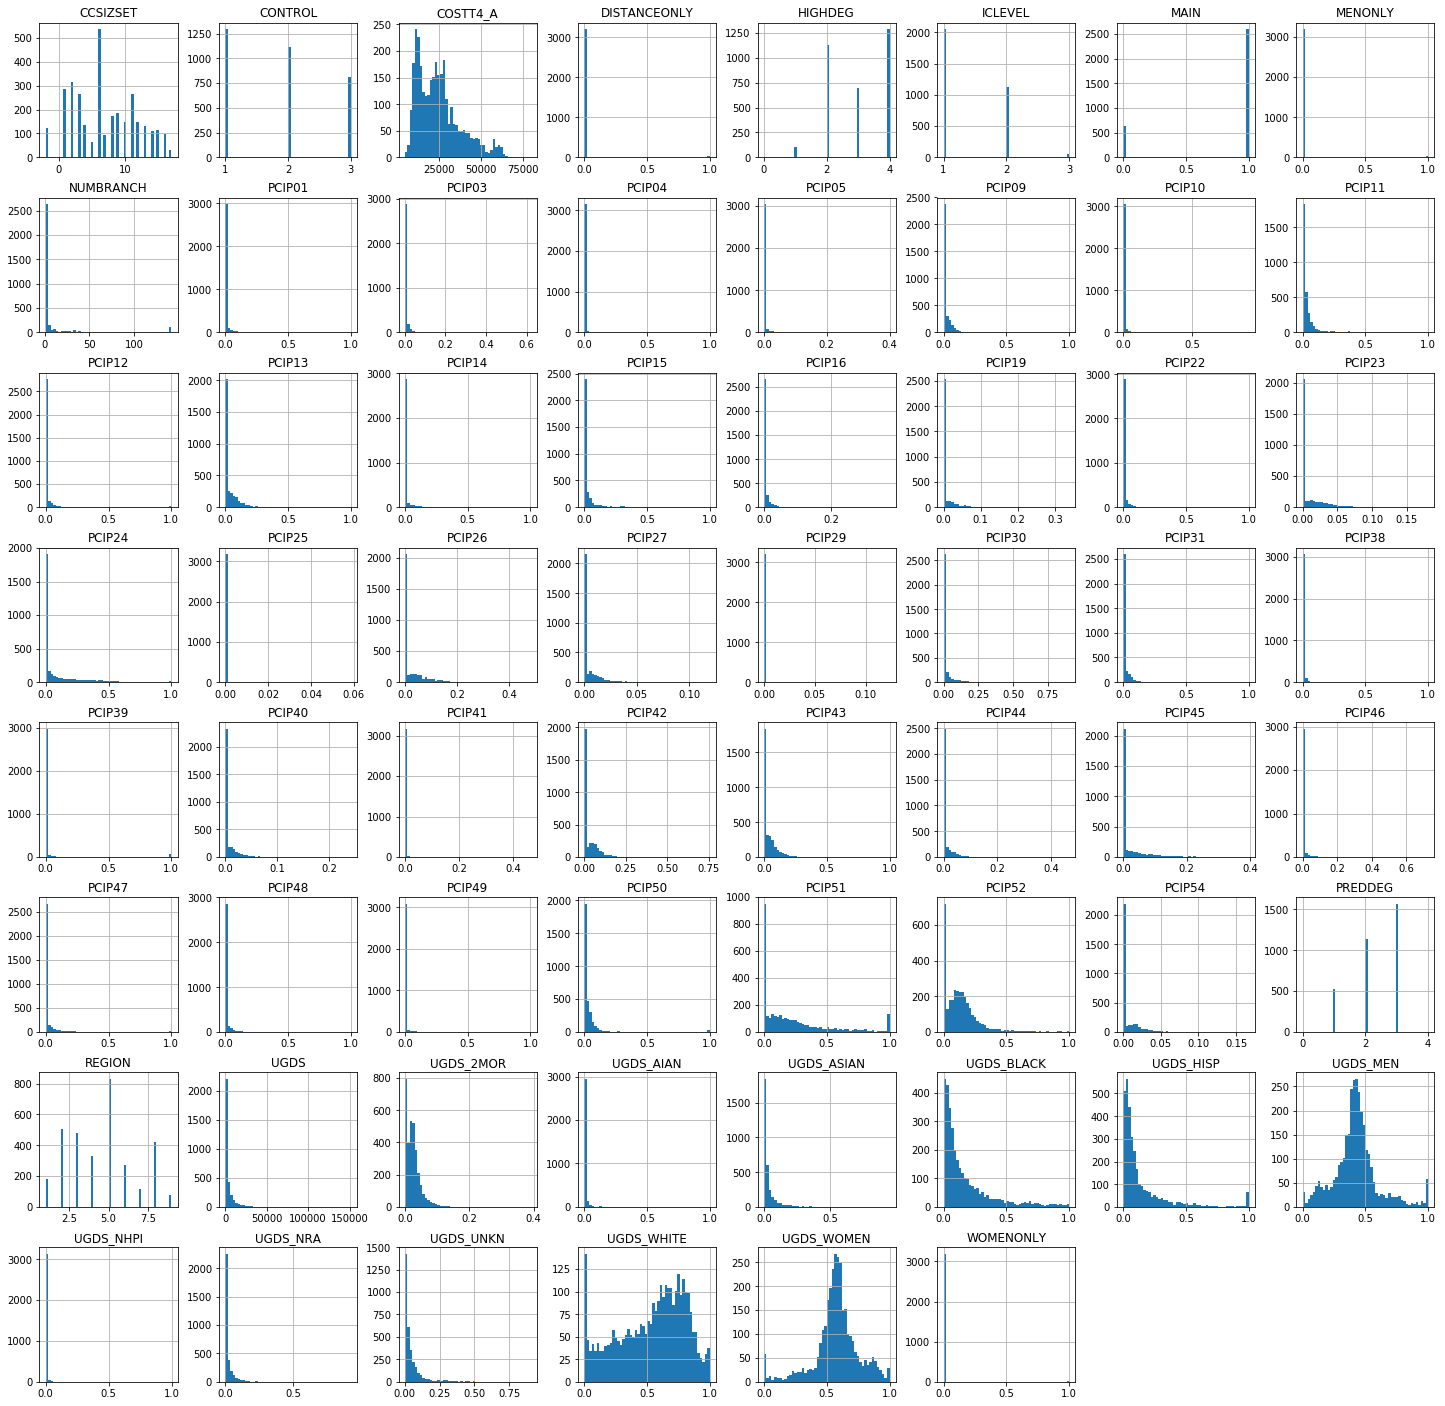

In [18]:
train_set.hist(bins=50, figsize=(25,25))
plt.show()

Let's explore the target variable (COSTT4_A) more closely through a scatter plot and a box plot.

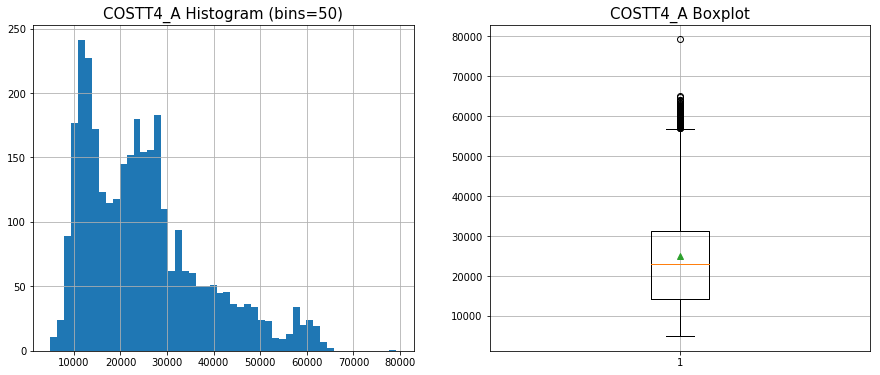

In [19]:
fig = plt.figure(figsize=(15,6))

#hist
ax1 = fig.add_subplot(121)
ax1.hist(train_set.COSTT4_A,bins=50)
ax1.grid(True)
plt.title("COSTT4_A Histogram (bins=50)", size=15)

#boxplot
ax2 = fig.add_subplot(122)
ax2.boxplot(train_set.COSTT4_A, showmeans=True)
ax2.grid(True)
plt.title("COSTT4_A Boxplot",  size=15)
plt.show()

The cost has a little longer tail on the right. We could try some transformation in the next round of modeling.

Check scatter plots, looking for interesting patterns.

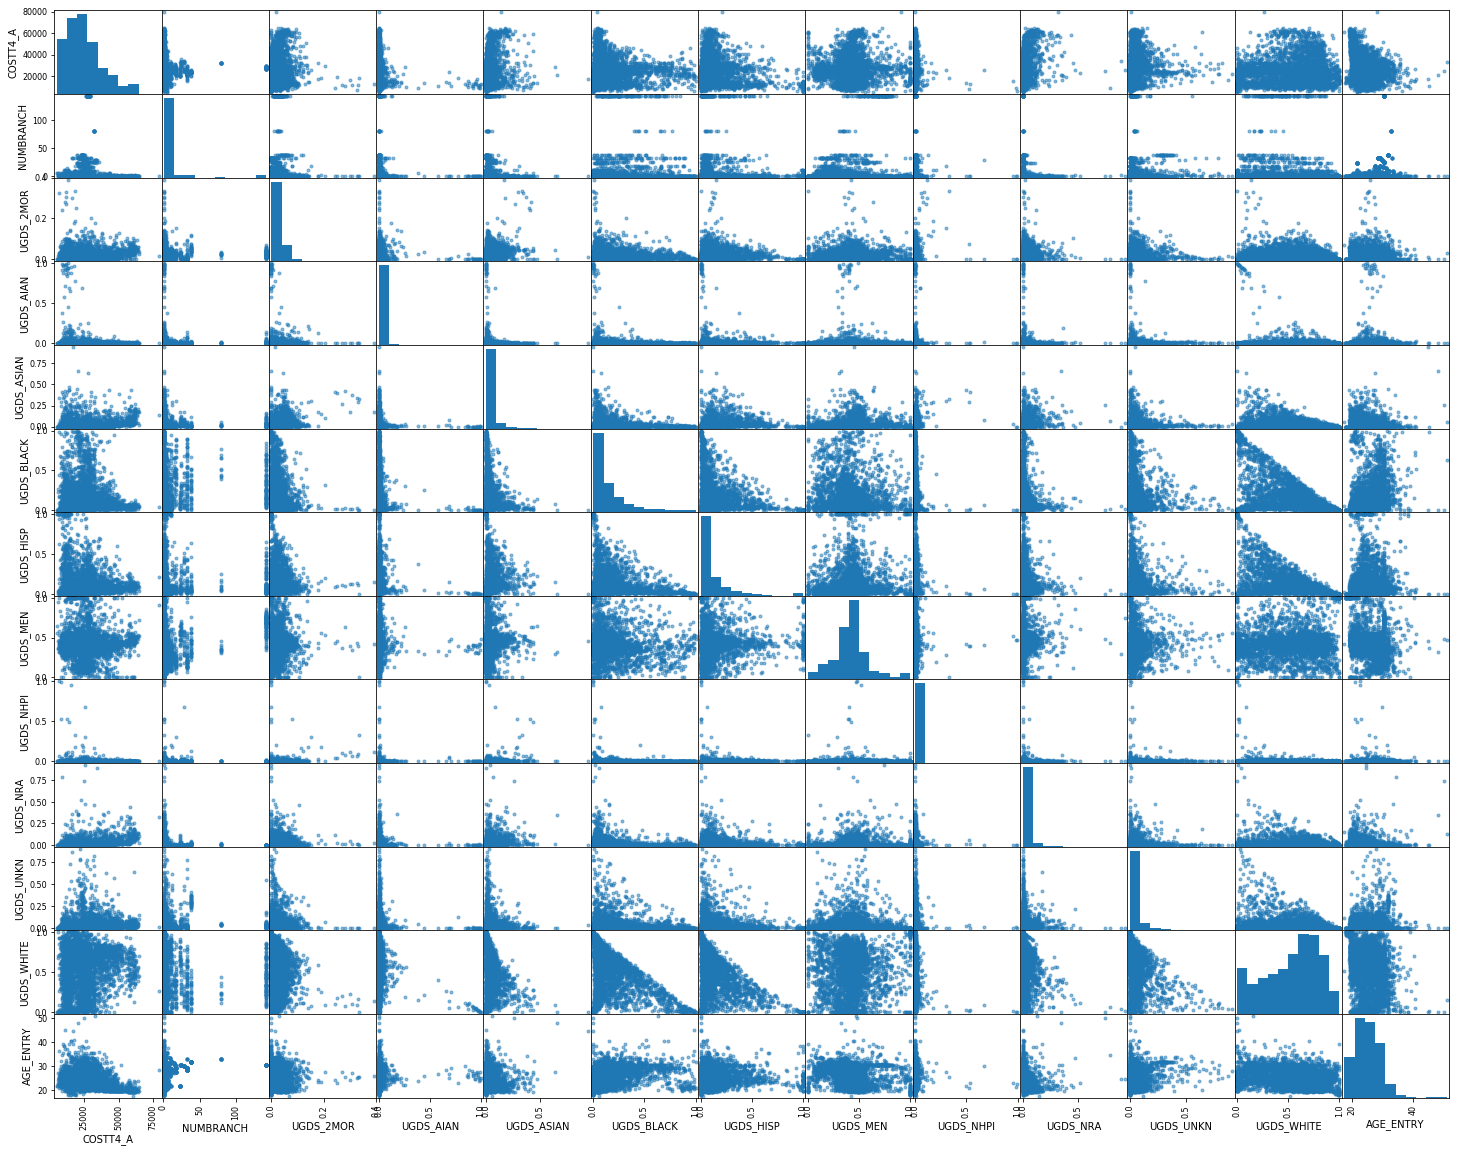

In [30]:
from pandas.tools.plotting import scatter_matrix

attributes = ["COSTT4_A", "NUMBRANCH","UGDS_2MOR", "UGDS_AIAN", "UGDS_ASIAN",
              "UGDS_BLACK", "UGDS_HISP", "UGDS_MEN", "UGDS_NHPI", "UGDS_NRA",
              "UGDS_UNKN", "UGDS_WHITE","AGE_ENTRY"]

scatter_matrix(train_set[attributes], figsize=(25, 20), alpha=0.5)
plt.show()

We can get a good summary of how relationships look from the output above

Let's now check if we still  have any missing values

In [23]:
print("TRAIN SET - Number of featues with at least 1 missing value: %s"
      %(train_set.isnull().sum() != 0).sum())
print("TEST SET - Number of featues with at least 1 missing value: %s"
      %(test_set.isnull().sum() != 0).sum())

TRAIN SET - Number of featues with at least 1 missing value: 0
TEST SET - Number of featues with at least 1 missing value: 0


We don't have any missing values. Otherwise, we'll have to either remove them or use a imputation method (mean, median, regression, ...)

## 3.MODEL

### 3.1. Custom transformers

Until now we've been exploring the data set and we figured out all the necessary steps we needed to get the data ready for machine learning models. To simplify the data preparation, we are going to create a pipeline that will get the original data set and it will output the transformed data set we then will feed into our models. 

In order to create a pipeline, we need to build custom transformers. Our custom transformers will inherit from `sklearn` classes (`BaseEstimator`, `TransformerMixin`) the following methods: `set_param`, `get_param`, and `fit_transform` (method that is used in the pipeline). The transformers will implement the same methods that sklearn classes do: `fit` and `transform`. 

The transformers we built are:

* **`feature_selection`**: it will select the features we are using for our model.
* **`one_hot`**: it will one-hot-encode categorical features, merge them with the data frame, and delete the original feature
* **`StandardScaler_df`**: relies on `sklearn StandardScaler` to standardized all columns passed as an argument. It also returns a data frame instead of a matrix to keep columns names [Not used as we didn't see any improvements]
* **`impute_PrivacySuppressed`**: Impute median value of column if there are strings equal to "PrivacySuppressed"

We will also create a function (`split`) to split the data set after the transformation. This split uses the same random seed as the split we used before.

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class one_hot(BaseEstimator, TransformerMixin):
    """This custom tranformer one-hot encodes columns. It returns a 
       data frame to keep column names instead of returning a matrix"""
    
    def __init__(self): 
        self.encoder = OneHotEncoder(sparse=False)       
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        
        # resets index to contatenate
        X.reset_index(drop=True,inplace=True)
        
        # CONTROL. Encodes -> To data frame to keep columns -> reset index to contatenate
        control_df = pd.DataFrame(self.encoder.fit_transform(X["CONTROL"].reshape(-1, 1)),
                                  columns=["CONTROL1","CONTROL2","CONTROL3"]).reset_index(drop=True)
        # concatenate one hot encoding and drop original column
        X = pd.concat([X, control_df], axis=1).drop("CONTROL",axis=1)
        
        # ICLEVEL. Encodes -> To data frame to keep columns -> reset index to contatenate
        iclevel_df = pd.DataFrame(self.encoder.fit_transform(X["ICLEVEL"].reshape(-1, 1)),
                                  columns=["ICLEVEL1","ICLEVEL2","ICLEVEL3"]).reset_index(drop=True)
        # concatenate one hot encoding and drop original column
        X = pd.concat([X, iclevel_df], axis=1).drop("ICLEVEL",axis=1)
        
        # REGION. Encodes -> To data frame to keep columns -> reset index to contatenate
        region_df = pd.DataFrame(self.encoder.fit_transform(X["REGION"].reshape(-1, 1)),
                                columns=["R1","R2","R3","R4","R5","R6","R7","R8","R9"]
                                ).reset_index(drop=True)
        # concatenate one hot encoding and drop original column
        X = pd.concat([X, region_df], axis=1).drop("REGION",axis=1)
        
        # CCSIZSET. Encodes -> To data frame to keep columns -> reset index to contatenate
        X["CCSIZSET"] = X["CCSIZSET"].map(lambda x: 500 if x<0 else x) #replace negative values
        ccsizset_df = pd.DataFrame(self.encoder.fit_transform(X["CCSIZSET"].reshape(-1, 1))
                                  ).reset_index(drop=True)
        # concatenate one hot encoding and drop original column
        X = pd.concat([X, ccsizset_df], axis=1).drop("CCSIZSET",axis=1)
                
        return X

    
class feature_selection(BaseEstimator, TransformerMixin):
    """This custom tranformer select the features passes as the 
       argument attribute_names"""
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
    
class StandardScaler_df(BaseEstimator, TransformerMixin):
    """This custom tranformer standarize features passed as attribute_names
       and rebuild the data frame to keep names of columns"""
    
    def __init__(self, attribute_names):
        self.scale = StandardScaler()
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        scale_df = pd.DataFrame(self.scale.fit_transform(X[self.attribute_names]),
                                columns = self.attribute_names)
        X.drop(self.attribute_names,axis=1,inplace=True)  
        X = pd.concat([X, scale_df], axis=1)             
        return X

    
class impute_PrivacySuppressed(BaseEstimator, TransformerMixin):
    """This custom tranformer imputes the median value of a column to  
       each observation with 'PrivacySuppressed' """
    
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        imputer = Imputer(strategy="median")
        X = X.replace('PrivacySuppressed',np.NaN)
        for col in X.columns.tolist():
            X[col] = imputer.fit_transform(X[col].reshape(-1, 1))
        return X

    
def split(X):
    """This function takes the college dataframe as a parameter and 
       returns train/test sets as a tuple. Stratify based on CONTROL"""
    
    # get rid of region 0
    X = X[X["REGION"] != 0]
    #stratified split based on CONTROL
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)
    for train_index, test_index in split.split(X, X["CONTROL"]):
        train_set = X.iloc[train_index]
        test_set = X.iloc[test_index]

    return(train_set,test_set)

### 3.2. Pipeline

Now that we have defined our transformers we can run our pipeline to get the transformed data. The pipeline will use the `fit_transform` method of each transformer at every step and it will pass the output to the next step of the pipeline. Once done, we use the split function to get our final train and test set. 

This is a summary of steps taken in the next cell:

* Load data set.
* Drop nulls of target variable.
* Split into training and test set.
* For each set, feed data to pipeline:
    * feature selection.
    * impute "PrivacySuppressed"
    * one hot encoding.
    
*[Note] From now on we can start executing the notebook from this cell.*

In [6]:
# load data
college2014 = pd.read_csv(COLLEGE_PATH+'/college2014.csv',
                          encoding = "ISO-8859-1",low_memory=False)
college2014.dropna(axis=0, subset=["COSTT4_A"], inplace=True)

#columns to keep
columns = ['COSTT4_A','CONTROL', 'MAIN', 'REGION', 'ICLEVEL', 'NUMBRANCH','PREDDEG',
           'HIGHDEG','MENONLY','WOMENONLY',"PCIP01", "PCIP03","PCIP04", "PCIP05",
           "PCIP09","PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15",
           "PCIP16", "PCIP19", "PCIP22","PCIP23", "PCIP24", "PCIP25", "PCIP26",
           "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38","PCIP39", "PCIP40",
           "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47",
           "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54", "UGDS_2MOR",
           "UGDS_AIAN", "UGDS_ASIAN","UGDS_BLACK", "UGDS_HISP", "UGDS_MEN",
           "UGDS_NHPI", "UGDS_NRA", "UGDS_UNKN", "UGDS_WHITE", "UGDS",
           "AGE_ENTRY", "DISTANCEONLY", "VETERAN", "CCSIZSET"]

# Not used
columns_scale = []

#pipeline
college_pipeline = Pipeline([('feature_selection', feature_selection(columns)),
                             ('impute_PrivacySuppressed',impute_PrivacySuppressed()),
                             ('one_hot', one_hot()),
                             #('std_scaler', StandardScaler_df(columns_scale)), 
                            ])
        

# run pipeline
train_set, test_set = split(college2014)
train_set = college_pipeline.fit_transform(train_set)
test_set = college_pipeline.fit_transform(test_set)

# check sets size
print("TRAIN SET rows: %s, columns: %s " %(train_set.shape[0],train_set.shape[1]))
print("TEST SET rows: %s, columns: %s " %(test_set.shape[0],test_set.shape[1]))

TRAIN SET rows: 3223, columns: 92 
TEST SET rows: 806, columns: 92 


Now we have our train and test set ready (see size on cell output). We have run all steps in the pipeline but `std_scaler` because we didn't see any improvement when using it (we also ended up using a Random Forest model which doesn't benefit from feature scaling). Note how easy is to add/remove steps if you are using a pipeline.

### 3.3. Model selection    

Next cell will divide train and test set into target variable (`y_train` and `y_test`) and predictors (`X_train`, `X_test`)

In [7]:
X_train = train_set.drop("COSTT4_A", axis=1)
y_train = train_set["COSTT4_A"]
X_test = test_set.drop("COSTT4_A", axis=1)
y_test = test_set["COSTT4_A"]

The next step is to try several models with our data (without hyperparameter tune up) to see which one yields better results.

We'll use cross validation 20-folds to get the score for each model (mean of all folds). The score function we are using is negative mean square errors which is the opposite of MSE as cross validation function expects a score where lower is better.

Using this procedure we are going to try the following models:

* Linear regression
* Decision Tree
* Random Forest

Each cell will output:

* Model: model used
* Scores: scores of each fold of cross validation. RMSE.
* Mean: mean of all Scores. RMSE. 
* Standard deviation: standard deviation of Scores. 

In [8]:
print("Model: Decision Tree Regressor")
tree_reg = DecisionTreeRegressor()

tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Model: Decision Tree Regressor
Scores: [ 6376.76561897  7752.29731502  5363.6481251   6607.67231406  7449.68376585
  5436.01455044  6120.62955598  7420.55730776  7216.65460941  5679.93056339
  6199.31630171  7152.68947203  8201.37383431  6613.7272476   6792.52189192
  6423.97771213  6429.21852181  6488.17522414  6477.58232638  7775.21626789]
Mean: 6698.88262629
Standard deviation: 756.764703038


In [9]:
print("Model: Linear Regression")
lin_reg = LinearRegression()

tree_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Model: Linear Regression
Scores: [ 5557.67118226  5989.40203843  4676.1818584   5979.31797769  6825.16635468
  4931.23095733  4896.02818496  5245.91320386  5204.77804842  5923.77130802
  4856.67121087  5736.90248475  5970.73243322  4881.81736352  4823.60720553
  6254.58621685  5937.77942292  5595.89350495  5291.68406848  5993.3367101 ]
Mean: 5528.62358676
Standard deviation: 570.034409336


In [10]:
print("Model: Random Forest Regressor")
forest_reg = RandomForestRegressor()

tree_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Model: Random Forest Regressor
Scores: [ 4298.43533785  5646.23398249  4284.88693728  5515.8895349   6088.79847215
  4175.82574003  4519.22035378  4499.94365682  4643.51809021  4789.63921644
  4353.33886873  5075.84873342  5388.20068988  4235.24285854  4545.75304142
  5156.62458853  4274.87720585  4901.43757282  4311.42239501  5832.54529661]
Mean: 4826.88412864
Standard deviation: 578.721719399


The best model (using `skilearn` default values for model parameters) is Random Forest. This model yields the best RMSE (4826.8) and the smallest standard deviation (578.7) which means it is more robust than the other models. We will now tune up the hyperparameters of the selected model.

### 3.4. Model tune up     

To tune up the hyperparameters we are going to do a `grid_search`. Using cross validaton `grid_search` will get the mean loss score for every combination of hyperparameters passed into the grid. The grid will then save the model which achieved the best score. This way we will be able to tune up our model without splitting the training set any more.

In [21]:
param_grid = [{'n_estimators': [550], 'max_features': [22,30],
               'bootstrap': [False], 'min_samples_leaf':[1,2], 
               'min_samples_split':[2,3]}]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.3min finished


Once we have ran we have run `grid_search` we can inspect several parameters of the object to assess the results. This next cell will show:

* Best hyper parameters
* Best model (showing all parameters)
* Best CV score.
* Scores for each parameter combination.

In [22]:
print(" ----------------- GRID_SEARCH INFO -----------------\n ")
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print("Best CV score:", np.sqrt(-grid_search.best_score_))

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

 ----------------- GRID_SEARCH INFO -----------------
 
{'max_features': 30, 'min_samples_leaf': 2, 'n_estimators': 550, 'min_samples_split': 3, 'bootstrap': False}
RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=30, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=2, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=550, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Best CV score: 4516.28020768
4525.37200146 {'max_features': 22, 'n_estimators': 550, 'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 2}
4526.47355183 {'max_features': 22, 'min_samples_leaf': 1, 'n_estimators': 550, 'min_samples_split': 3, 'bootstrap': False}
4519.80282799 {'max_features': 22, 'min_samples_leaf': 2, 'n_estimators': 550, 'min_samples_split': 2, 'bootstrap': False}
4521.8054995 {'max_features': 22, 'n_estimators': 550, 'bootstrap': False, 'min_samples_leaf'

Above we can see our final model and the score mean CV score on the training set. The score is better than the one we achieved without hyper parameter tuning. We'll keep the model and we'll use it as our final model to predict the cost.

We also wanted to find out which features have more influence on the average cost of an institution. In order to do that we can check the features that have been used more often in the splits of the random forest model. We'll show a bar chart with the 40 most important features and then we will print all features.

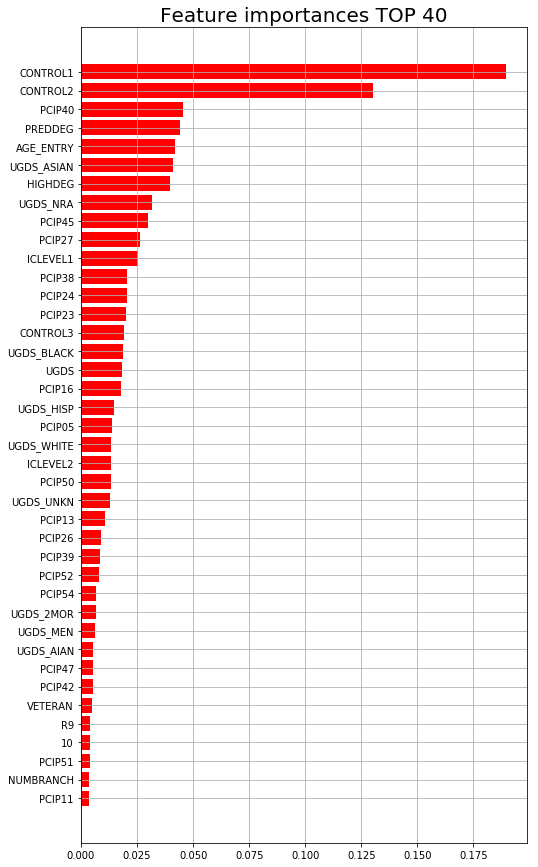

(0.18959768993437698, 'CONTROL1')
(0.13046337371578026, 'CONTROL2')
(0.045458986103124925, 'PCIP40')
(0.044347547230823958, 'PREDDEG')
(0.041982581999914996, 'AGE_ENTRY')
(0.041267831620935912, 'UGDS_ASIAN')
(0.039539444138108872, 'HIGHDEG')
(0.031759371673114031, 'UGDS_NRA')
(0.029789674287213588, 'PCIP45')
(0.026503941654773995, 'PCIP27')
(0.025595587009745562, 'ICLEVEL1')
(0.020605845784655123, 'PCIP38')
(0.020383238975600338, 'PCIP24')
(0.020217556544136202, 'PCIP23')
(0.019194445183596275, 'CONTROL3')
(0.018863929670893773, 'UGDS_BLACK')
(0.018327805098688286, 'UGDS')
(0.017650468668005966, 'PCIP16')
(0.014691179948338195, 'UGDS_HISP')
(0.013987391421348187, 'PCIP05')
(0.013420690159723801, 'UGDS_WHITE')
(0.013316451629239426, 'ICLEVEL2')
(0.013282949677222487, 'PCIP50')
(0.0129666605024489, 'UGDS_UNKN')
(0.010809626023011583, 'PCIP13')
(0.0089381514062915821, 'PCIP26')
(0.0085112784525731965, 'PCIP39')
(0.0082395711289871675, 'PCIP52')
(0.0068655496183052519, 'PCIP54')
(0.0065324

In [23]:
# feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(feature_importances)[::-1]
attributes = X_train.columns
fimpotances = sorted(zip(feature_importances, attributes), reverse=True)

# plot 15 most important features 
plt.figure(figsize=(8, 15))
plt.barh(range(40), feature_importances[indices][:40], color="r", align="center")
plt.yticks(range(40), [x[1] for x in fimpotances][:40])
plt.title("Feature importances TOP 40", size=20)
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

# print all features (text)
for f in fimpotances:
    print(f)

From the output above we can infer:

- The type of institution plays a crucial role in the cost (CONTROL1, CONTROL2, CONTROL3) accounting for almost 35% of the splits.
- Another important feature is the types of degrees offered (PREDDEG, HIGHDEG)
- Age entry to the institution is also present on many splits.
- Total share of undergraduate students that are either Asian or Non-resident aliens are also important in determining the price 
- Some specific types of degrees also influence the price as the percentage of degrees awarded in Physical Sciences (PCIP40) and Social Sciences (PCIP45)

[NOTE] With random forest we can tell which features are important but we can't determine in which way. To get that information we'll have to use a another model like linear regression.


### 3.5. Final model

We now have our final model. In order to see how it will do with unseen data we are going to use the test set

In [24]:
final_model = grid_search.best_estimator_
# predictions
final_predictions = final_model.predict(X_test)
# calculate RMSE
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)   # => evaluates to 4323
final_rmse

4333.6151333416828

The final RSME for unseen data is 4333.6. This means that every prediction has around 66% chance of being that range.

The model yielded similar results with the training set (CV) and the test set, thus, we are not over fitting.

In order to get a better sense of the results we can plot the observed values and the predicted values. 

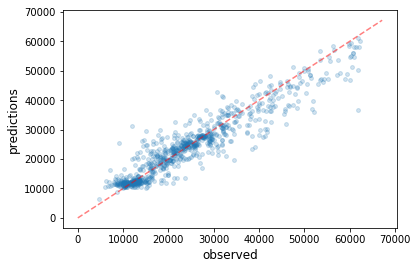

In [25]:
plt.scatter(y_test,final_predictions,alpha=0.2, s=15)
plt.xlabel('observed', fontsize=12)
plt.ylabel('predictions', fontsize=12)
plt.plot([0,(np.max(y_test) + 5000)],[0,(np.max(y_test) + 5000)], 'r--', alpha=0.5)
plt.show()

If all the predictions were perfect the points will lay on the red line. In our case, except a few outliers, most of the points are close to the line which means we are making good predictions.

### 3.6. Additional comments
    
* We could use linear regression to interpret each coefficient and have a better understanding of how each feature affects the price.
* Try to add/remove features to improve the model.
* Add other techniques to our pipeline.
* Try to get more data, maybe using other years.

### The end